<h3> Removing top layer of efficient net and loading our own classification layer</h3>

references:<br>
<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/">Tensorflow Documentation - Layers</a><br>
<a href="https://arxiv.org/pdf/1905.11946.pdf">Efficient Net and how it works</a><br>
<a href="https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/">Keras example for fine tuning</a><br>
<a href="https://www.tensorflow.org/guide/keras/train_and_evaluate">Tensorflow Documentation - Compiling and Evaluating</a><br>
<a href="https://keras.io/api/optimizers/">Keras Documentation - Optimisers</a><br>
<a href="https://keras.io/api/metrics/">Keras Documentation - Metrics</a><br>
<a href="https://keras.io/api/losses/">Keras Documentation - Losses</a><br>



In [145]:
# importing required packages
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0 as enet
from tensorflow.keras import models
from tensorflow.keras import layers

from PIL import Image, ImageDraw

In [146]:
# loading pretrained model, setting input shape
inputs = (224, 224, 3)

# Selecting a topless model (sounds damn good...)
basemodel = enet(include_top=False, input_shape=inputs, weights="imagenet")

# locking the trained weights (freezing?)
basemodel.trainable = False 

# checking out how its like
basemodel.summary()

e_expand[0][0]          
__________________________________________________________________________________________________
block5b_project_conv (Conv2D)   (None, 14, 14, 112)  75264       block5b_se_excite[0][0]          
__________________________________________________________________________________________________
block5b_project_bn (BatchNormal (None, 14, 14, 112)  448         block5b_project_conv[0][0]       
__________________________________________________________________________________________________
block5b_drop (Dropout)          (None, 14, 14, 112)  0           block5b_project_bn[0][0]         
__________________________________________________________________________________________________
block5b_add (Add)               (None, 14, 14, 112)  0           block5b_drop[0][0]               
                                                                 block5a_project_bn[0][0]         
____________________________________________________________________________________

In [147]:
# to rebuild top layer for our own classification

dropout_rate = 0.1 #i_dunno_yet - supposed to prevent overfit
types = 2 #currently only mask and no mask 

# building up the model in sequence
model = models.Sequential()

# loading the original topless model
model.add(basemodel)

# adding global pooling 2d to remove the columns and rows output from previous layer
model.add(layers.GlobalMaxPooling2D(name="gap"))

# adding the dropout and subsequently the softmax layer
model.add(layers.Dropout(dropout_rate, name="drout"))
model.add(layers.Dense(types, activation="softmax", name="classdense"))

# view the assembled model
model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
drout (Dropout)              (None, 1280)              0         
_________________________________________________________________
classdense (Dense)           (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


In [161]:
# todo - image preprocessing function (to check)

def make_tf_dataset(media_folder):
    type_names = []
    tf_img_array = []

    for pic in os.listdir(media_folder): 
            image = os.path.join(media_folder, pic)
            image = tf.io.read_file(image)
            image = tf.io.decode_jpeg(image, channels = 3)
            image = tf.image.resize(image, (224, 224))
            image = tf.cast(image / 255, tf.float32)
            tf_img_array.append(image)
            type_names.append(media_folder)
    
    type_names = set(type_names)
    return tf.stack(tf_img_array, axis = 0), type_names

Number of items in  ../data/training  =  23
886-with-mask.JPG


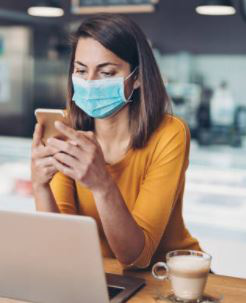

825-with-mask.jfif


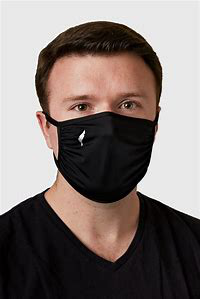

885-with-mask.JPG


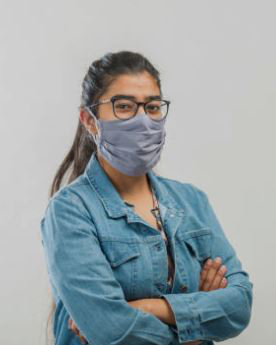

In [180]:
# setting image folder
media_folder = "../data/training"

# to-do: code the sample display of the original images
_, _, filenames = next(os.walk(media_folder))

foldersize = len(filenames)
print("Number of items in ", media_folder, " = ", foldersize)
sampling = 3

for i in range (0,sampling): 
    pil_im = Image.open(media_folder + "/" + filenames[i])
    display(pil_im)
    print(filenames[i])

# executing the create image function, returns two 

tf_img_array, type_names = make_tf_dataset(media_folder)

In [167]:

tf_img_array

<tf.Tensor: shape=(23, 224, 224, 3), dtype=float32, numpy=
array([[[[2.3921569e-01, 2.3921569e-01, 2.7058825e-01],
         [2.3921569e-01, 2.3921569e-01, 2.7058825e-01],
         [2.3842259e-01, 2.3842259e-01, 2.6979515e-01],
         ...,
         [2.5861308e-01, 3.0670470e-01, 3.3904019e-01],
         [3.3214828e-01, 3.8312867e-01, 4.1450125e-01],
         [3.9830014e-01, 4.5673844e-01, 4.8438203e-01]],

        [[2.4129027e-01, 2.3921569e-01, 2.7058825e-01],
         [2.4129027e-01, 2.3921569e-01, 2.7058825e-01],
         [2.4129027e-01, 2.3921569e-01, 2.7058825e-01],
         ...,
         [2.4487346e-01, 2.9296511e-01, 3.2530057e-01],
         [3.1286675e-01, 3.6384714e-01, 3.9521968e-01],
         [3.7516573e-01, 4.3360400e-01, 4.6124762e-01]],

        [[2.4313726e-01, 2.3921569e-01, 2.7058825e-01],
         [2.4313726e-01, 2.3921569e-01, 2.7058825e-01],
         [2.4313726e-01, 2.3921569e-01, 2.7058825e-01],
         ...,
         [2.2801965e-01, 2.7611127e-01, 3.0844676e-01],

In [168]:
# to compile the model (specifying optimser, loss and metrics) - I_dunno_need_adj_later

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )


# fitting the processed images into the model

batch_size = 32
epochs_to_run = 10

print("Fit model on training data")
history = model.fit(tf_img_array, type_names, batch_size = batch_size, epochs = epochs_to_run)


"""
okay i dont think i can code anything more based on imaginations hahaha. 
Im sure the codes above are full of bugs too
I'll go think about how to deploy the damn thing then continue with the fine tuning after we do a trial run
"""

NameError: name 'keras' is not defined

In [ ]:
# to-do: finetuning other layers of the pretrained model



In [ ]:
# to-do: fit the training set into the fine-tuned model to see if theres improvements


In [ ]:
# to-do: process validation data and validate model with validation data set


In [ ]:
# to-do: write entry script for web api


In [ ]:
# to-do: packing up the model (docker) and deploy (it will be a nightmare)


In [ ]:
# to-do: deploy model on cloud space, verify service is running


In [ ]:
# to-do: test model (and profit)
